In [1]:
from platform import python_version
python_version()

'3.8.8'

In [2]:
import os
import pandas as pd
import json
import tqdm
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import collections
from motif_utils import seq2kmer

In [3]:
import css_utility

In [4]:
from css_utility import *

In [5]:
path='../database/bed/unzipped/'
bed_files=os.listdir(path)

In [6]:
all_files=file_list_maker(path, bed_files)

In [75]:
all_files[0]

'../database/bed/unzipped/E001_15_coreMarks_stateno.bed'

In [7]:
test_file_bed=all_files[0]
df=bed2df_expanded(test_file_bed)

In [8]:
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [9]:
df_chr_list=df2chr_df(df)

In [10]:
len(df_chr_list)

25

In [11]:
df.groupby("chromosome").count()

,start,end,state,length,unit,state_seq,state_seq_full
chromosome,,,,,,,
chr1,45244,45244,45244,45244,45244,45244,45244
chr10,22932,22932,22932,22932,22932,22932,22932
chr11,25030,25030,25030,25030,25030,25030,25030
chr12,25313,25313,25313,25313,25313,25313,25313
chr13,13936,13936,13936,13936,13936,13936,13936
chr14,15750,15750,15750,15750,15750,15750,15750
chr15,15012,15012,15012,15012,15012,15012,15012
chr16,15782,15782,15782,15782,15782,15782,15782
chr17,22095,22095,22095,22095,22095,22095,22095


In [12]:
all_unit_css=df2unitcss(df)
len(all_unit_css)

24

In [22]:
set(all_unit_css[0][:3000])

{'A', 'I', 'O'}

In [26]:
all_unit_css[0][:3000].count("O")

2993

In [27]:
test_6mer=seq2kmer(all_unit_css[0],6)

In [28]:
type(test_6mer)

str

In [29]:
len(test_6mer)

8723735

In [42]:
test_6mer[:100][6]==' '

True

In [65]:
def colored_css_str_as_is(sub_str):
    col_str=""
    for letter in sub_str:
        if letter==" ":
            col_str+=" "
        else:                
            for state in list(state_col_255_dict.keys()):
                if letter==state:
                    r=state_col_255_dict[letter][0]
                    g=state_col_255_dict[letter][1]
                    b=state_col_255_dict[letter][2]
                    col_letter="\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r,g,b,letter)
                    col_str+=col_letter
    return print("\033[1m"+col_str+"\033[0;0m") 

In [66]:
colored_css_str_as_is(test_6mer[300:350])

 O O O O O O  O O O O O I  O O O O I I  O O O I I I  O O I I I I  O I I I I O  I I I I O O  


In [76]:
len(all_unit_css[:])

24

In [77]:
# flattening list of list
flat_css=[item for sublist in all_unit_css for item in sublist]

In [78]:
len(flat_css)

15478375

In [80]:
flat_css.count("O")/len(flat_css)

0.7097894320301711

In [81]:
flat_css.count("A")/len(flat_css)

0.00998321852261623

In [110]:
pd.concat([prop_data_01["state (Emission order)"],prop_data_01["Genome %"]], axis=1)

,state (Emission order),Genome %
0,1_TssA,0.99832
1,2_TssAFlnk,0.25765
2,3_TxFlnk,0.02896
3,4_Tx,1.37933
4,5_TxWk,14.20635
5,6_EnhG,0.09142
6,7_Enh,3.73125
7,8_ZNF/Rpts,0.25855
8,9_Het,2.65723
9,10_TssBiv,0.40156


In [115]:
a_df=pd.DataFrame(prop_data_01["state (Emission order)"])

In [119]:
a_s=prop_data_01["Genome %"]

In [134]:
a_s.index()

TypeError: 'RangeIndex' object is not callable

In [121]:
n_df=pd.concat([a_df,a_s], axis=1)

In [122]:
pd.concat([n_df,a_s], axis=1)

,state (Emission order),Genome %,Genome %
0,1_TssA,0.99832,0.99832
1,2_TssAFlnk,0.25765,0.25765
2,3_TxFlnk,0.02896,0.02896
3,4_Tx,1.37933,1.37933
4,5_TxWk,14.20635,14.20635
5,6_EnhG,0.09142,0.09142
6,7_Enh,3.73125,3.73125
7,8_ZNF/Rpts,0.25855,0.25855
8,9_Het,2.65723,2.65723
9,10_TssBiv,0.40156,0.40156


In [346]:
def prop_data2df(path='../database/conserv_overlap/', state_list=state_list):
    file_list=[os.path.join(path, file) for file in os.listdir(path)]
    
    temp_df=pd.read_csv(file_list[0],sep='\t', lineterminator='\n')
    init_col=pd.DataFrame(temp_df["state (Emission order)"])
    init_col=init_col.rename(columns={"state (Emission order)":"state"})
    for file in file_list:
        file_name=file.split('/')[3]
        sample_name=file_name.split('_')[0]

        prop_data=pd.read_csv(file, sep='\t', lineterminator='\n')
        prop=prop_data["Genome %"]
        temp_df=pd.concat([init_col,prop], axis=1)
        temp_df=temp_df.rename(columns={"Genome %":str(sample_name)})
        init_col=temp_df
    
    # show the result df (first col=state, other col=samples)
    temp_df.drop(temp_df.tail(1).index, inplace=True) # remove the last row (100%)
    
    # transposed and trimmed df (col+1=state no. row=samples)
    trans_df=temp_df.T
    trans_df.drop(trans_df.head(1).index, inplace=True)
    trans_df.columns=temp_df["state"].to_list()
    
    state_list=temp_df["state"].to_list()
    
    ## create a plot for genome proportion across cell types
    fig=plt.figure(figsize=(9,5))
    ax=fig.add_subplot(111)
    for i in range(len(state_list)):
        state=list(css_color_dict.keys())[i]
        state_as_colname=list(trans_df.columns)[i]

        color=tuple([elm/255 for elm in css_color_dict[state]])

        bp=ax.boxplot(trans_df.iloc[:,i],widths=0.65,positions = [i+1], notch=True,patch_artist=True, 
                     boxprops=dict(facecolor=color, color="gray"),whiskerprops=dict(color="gray", linewidth=2),
                     medianprops=dict(color=color, linewidth=2),
                     capprops=dict(color="gray", linewidth=2),
                     flierprops=dict(markeredgecolor=color, markeredgewidth=1.5))
    plt.xticks(list(range(1,16)),list(trans_df.columns))
    plt.xlabel("Chromatin state")
    plt.ylabel("Genome [%]\n across Different Cell Types")
    fig.autofmt_xdate(rotation=45)
    plt.show()
    
    return temp_df, trans_df

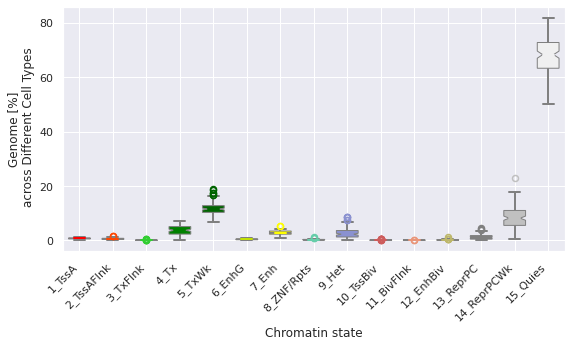

In [347]:
temp_df, trans_df=prop_data2df(path='../database/conserv_overlap/')

In [304]:
css_color_dict.keys()

dict_keys(['TssA', 'TssAFlnk', 'TxFlnk', 'Tx', 'TxWk', 'EnhG', 'Enh', 'ZNF/Rpts', 'Het', 'TssBiv', 'BivFlnk', 'EnhBiv', 'ReprPC', 'ReprPCWk', 'Quies'])

In [330]:
list(range(1,15))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [ ]:
## cutting telomere

In [395]:
len(all_unit_css[0])

1246253

In [402]:
len(all_unit_css[0][1246240:])

13

In [403]:
all_unit_css[0][607000:675250]

'OOOOOOOOOOOOOIIIIOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIIIIIIIIIIIIIOOOOOOOOOOOOOOOOOOOOOOOOOOIHHIIOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIIIIIOOOOOOOOOOOOOOOIHHEEEEEHHHIIIIIIIIIIIIIIIIIIIKKKKKKKOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

In [348]:
fa_file_path="../database/hg19/genome.fa"

In [363]:
str_eg="NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"
str_eg.count("N")

50

In [360]:
chr_list=["chr1","chr2","chr3","chr4,","chr5","chr6","chr7","chr8",
          "chr9","chr10","chr11","chr12,","chr13","chr14","chr15","chr16",
          "chr17","chr18","chr19","chr20,","chr21","chr22","chrX","chrY","chrM"]

In [392]:
with open(fa_file_path) as infile:
    for i, line in enumerate(infile):
        if ">" in line:
            no_n=0
            print(i+1)
            print(line)  
        elif "N" in line:
            no_n+=line.count("N")
        else:
            break
    print(no_n)

1
>chr1

10000


In [382]:
def fa2reducedBy50(fa_file_path):
    with open(fa_file_path) as infile:
        print("".join(line[0] for line in infile if not ">"))

In [383]:
fa2reducedBy50(fa_file_path)